**ML PROBLEM 4.2**

In [14]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import os


**Loading the data from the files given**

In [2]:
# Loading the data from the files given

X_train = np.load(os.path.abspath('X_train_regression2.npy'))
y_train = np.load(os.path.abspath('y_train_regression2.npy'))
X_test  = np.load(os.path.abspath('X_test_regression2.npy'))

**Normalization and Clustering of the data**

In [71]:
from sklearn import preprocessing
X_train_norm = preprocessing.normalize(X_train)


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)
model1_indices =  [ind for ind, x in enumerate((kmeans.labels_).tolist()) if x == 1]


X_train_model0 = X_train.copy()
X_train_model1 = X_train.copy()
y_train_model0 = y_train.copy()
y_train_model1 = y_train.copy()


X_train_model0 = np.delete(X_train_model0, model1_indices, 0)
y_train_model0 = np.delete(y_train_model0, model1_indices, 0)


X_train_model1 = X_train[model1_indices,:]
y_train_model1 = y_train[model1_indices,:]

<Axes: xlabel='Column3', ylabel='Column4'>

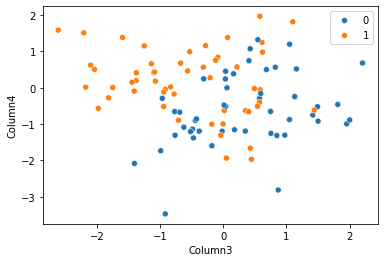

In [33]:
import seaborn as sns
df = pd.DataFrame(X_train, columns=['Column1', 'Column2', 'Column3','Column4'])
sns.scatterplot(data = df, x = 'Column3', y='Column4', hue = kmeans.labels_)

**Prediction for model 0**

In [97]:
X_train_mean0  = np.mean(X_train_model0,axis=0) 
y_train_mean0  = np.mean(y_train_model0,axis=0)

X_train_prime0 = X_train_model0.copy()
y_train_prime0 = y_train_model0.copy()

for i in range(X_train.shape[1]):
    X_train_prime0[:,i] = X_train_prime0[:,i] -  X_train_mean0[i]

# y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
y_train_prime0 = y_train_prime0 - y_train_mean0 



LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=8,fit_intercept=False,random_state=0).fit(X_train_prime0, y_train_prime0) 
LassoModel = Lasso(LassoModelCV.alpha_).fit(X_train_prime0, y_train_prime0) 
beta_hat_lasso  = LassoModel.coef_ # Beta Coefficients from the LASSO Regularization


# Removal of the unnecessary columns from the X data
X_train_prime_lasso_ridge0 = X_train_prime0.copy()
X_test_lasso_ridge_model0 = X_test.copy()
for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
    if beta_hat_lasso[i]==0:
        X_train_prime_lasso_ridge0 = np.delete(X_train_prime_lasso_ridge0, i, 1)
        X_test_lasso_ridge_model0 = np.delete(X_test_lasso_ridge_model0, i, 1)
        X_train_mean0 = np.delete(X_train_mean0, i, axis = 0)



RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=5).fit(X_train_prime_lasso_ridge0, y_train_prime0)
beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


beta_zero_model0 = y_train_mean0 - np.matmul((X_train_mean0),np.transpose(beta_hat_ridge))
m = [beta_zero_model0[0]]
for k in range(((beta_hat_ridge).shape[1])):
        m.append(beta_hat_ridge[:,k][0])
beta_hat_lasso_ridge_model0 = np.array(m)


c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.56817040280928, tolerance: 0.0074324537585645275
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Prog

**Prediction for model 1**

In [96]:
X_train_mean1  = np.mean(X_train_model1,axis=0) 
y_train_mean1  = np.mean(y_train_model1,axis=0)

X_train_prime1= X_train_model1.copy()
y_train_prime1 = y_train_model1.copy()

for i in range(X_train.shape[1]):
    X_train_prime1[:,i] = X_train_prime1[:,i] -  X_train_mean1[i]

# y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
y_train_prime1 = y_train_prime1 - y_train_mean1 



LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=15,fit_intercept=False,random_state=0).fit(X_train_prime1, y_train_prime1) 
LassoModel = Lasso(LassoModelCV.alpha_).fit(X_train_prime1, y_train_prime1) 
beta_hat_lasso  = LassoModel.coef_ # Beta Coefficients from the LASSO Regularization

# Removal of the unnecessary columns from the X data
X_train_prime_lasso_ridge1= X_train_prime1.copy()
X_test_lasso_ridge_model1 = X_test.copy()
for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
    if beta_hat_lasso[i]==0:
        X_train_prime_lasso_ridge1 = np.delete(X_train_prime_lasso_ridge1, i, 1)
        X_test_lasso_ridge_model1 = np.delete(X_test_lasso_ridge_model1, i, 1)
        X_train_mean1 = np.delete(X_train_mean1, i, axis = 0)



RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=5).fit(X_train_prime_lasso_ridge1, y_train_prime1)
beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


beta_zero_model1 = y_train_mean1 - np.matmul((X_train_mean1),np.transpose(beta_hat_ridge))
m = [beta_zero_model1[0]]
for k in range(((beta_hat_ridge).shape[1])):
        m.append(beta_hat_ridge[:,k][0])
beta_hat_lasso_ridge_model1 = np.array(m)



c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.828057096981222, tolerance: 0.007202391301952269
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Prog

**Prediction on X Test using model 0**


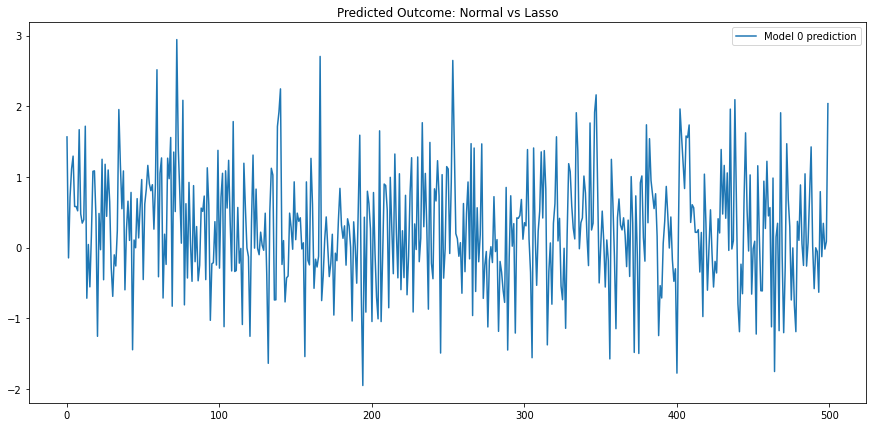

In [101]:
X_test_final_model0 = np.hstack((np.ones((1000,1)),X_test_lasso_ridge_model0))
prediction_model0 = np.matmul(X_test_final_model0,beta_hat_lasso_ridge_model0)
prediciton_model0 = prediction_model0.reshape(1000,1)

**Prediction on X Test using model 1**

In [102]:
X_test_final_model1 = np.hstack((np.ones((1000,1)),X_test_lasso_ridge_model1))
prediction_model1 = np.matmul(X_test_final_model1,beta_hat_lasso_ridge_model1)
prediciton_model1 = prediction_model1.reshape(1000,1)

**Comparison of the predictions given by Model 0 and Model 1**

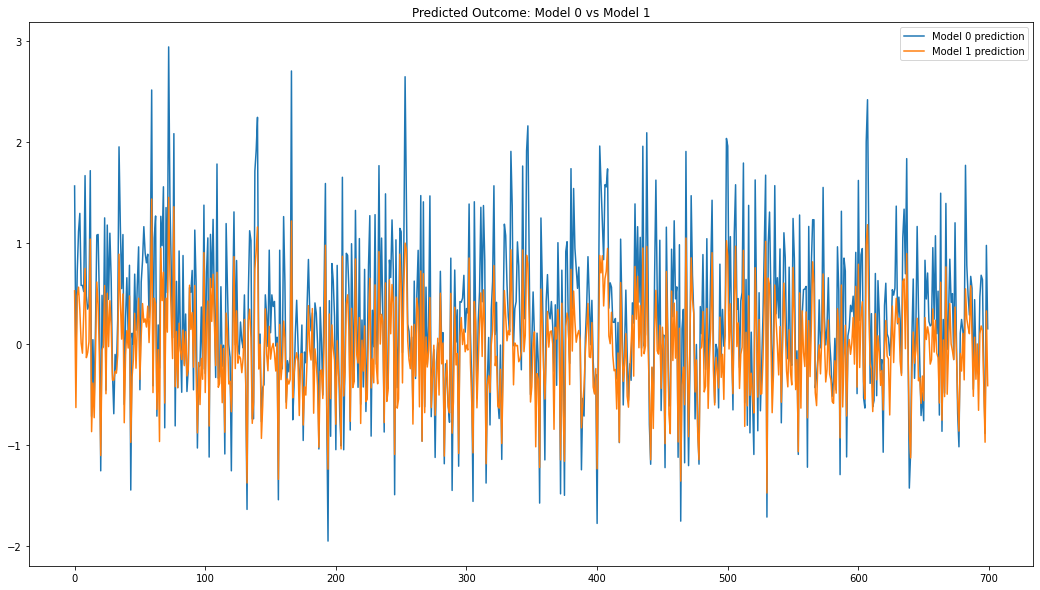

In [104]:
# Plotting the results
plt.figure(figsize=(18,10))
plt.plot(prediction_model0[0:700],label='Model 0 prediction')
plt.plot(prediction_model1[0:700],label='Model 1 prediction')

plt.title('Predicted Outcome: Model 0 vs Model 1')
plt.legend()

**Merging the two solutions**

In [111]:
prediction = np.transpose(np.vstack((prediction_model0,prediction_model1)))
#np.save('prediction_100123_100260_4.2',prediction)

[[ 1.56566449  0.52668201]
 [-0.14671722 -0.62974448]
 [ 0.7126349   0.47519721]
 ...
 [-0.01799461 -0.25793792]
 [ 0.912438    0.48612399]
 [ 0.01530982 -0.54662281]]
